In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")

In [19]:
#Load data
fraud_df = pd.read_csv(r"C:\Users\hp\Pictures\Adey Innovations inc\Fraud-Detection-for-E-commerce-and-Bank-Transactions\data\Fraud_Data.csv")
ip_df= pd.read_csv(r"C:\Users\hp\Pictures\Adey Innovations inc\Fraud-Detection-for-E-commerce-and-Bank-Transactions\data\IpAddress_to_Country.csv")
print(fraud_df.head())

   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  


In [11]:
#handling missing values 
fraud_df = fraud_df.dropna()


In [12]:
#Remove duplicates
fraud_df= fraud_df.drop_duplicates()


In [13]:
#Correct data types
#Time features must be datetime to engineer velocity and behavior patterns.
fraud_df["signup_time"] = pd.to_datetime(fraud_df["signup_time"])
fraud_df["purchase_time"] = pd.to_datetime(fraud_df["purchase_time"])
fraud_df["ip_address"] = fraud_df["ip_address"].astype("int64")


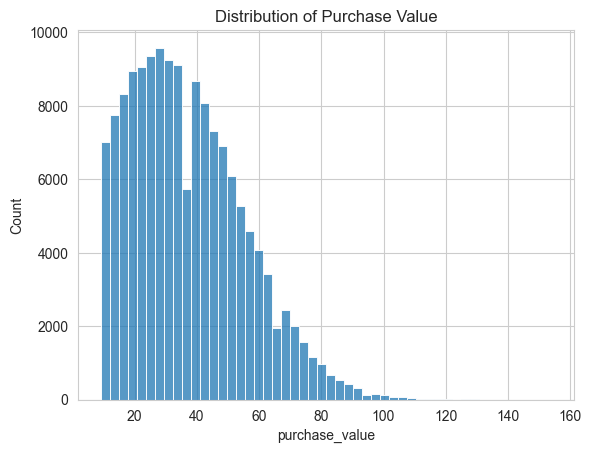

In [14]:
#Univariate analysis
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(fraud_df["purchase_value"], bins=50)
plt.title("Distribution of Purchase Value")
plt.show()



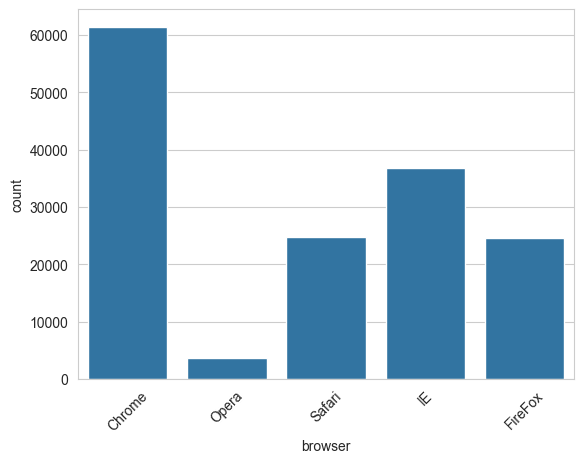

In [15]:
sns.countplot(x="browser", data=fraud_df)
plt.xticks(rotation=45)
plt.show()

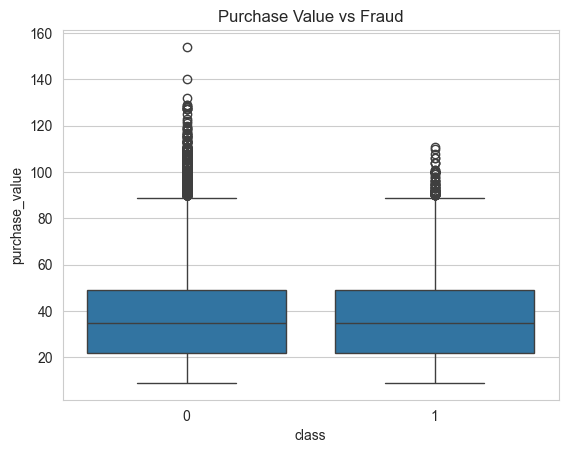

In [16]:
#Bivariate analysis (feature vs target)
sns.boxplot(x="class", y="purchase_value", data=fraud_df)
plt.title("Purchase Value vs Fraud")
plt.show()


In [17]:
#Class distribution (imbalance)
fraud_df["class"].value_counts(normalize=True)


class
0    0.906354
1    0.093646
Name: proportion, dtype: float64

In [20]:
#Convert IP ranges to integers
ip_df["lower_bound_ip_address"] = ip_df["lower_bound_ip_address"].astype("int64")
ip_df["upper_bound_ip_address"] = ip_df["upper_bound_ip_address"].astype("int64")


In [21]:
#Range-based lookup
ip_df = ip_df.sort_values("lower_bound_ip_address")

def map_ip_to_country(ip):
    row = ip_df[
        (ip_df["lower_bound_ip_address"] <= ip) &
        (ip_df["upper_bound_ip_address"] >= ip)
    ]
    return row.iloc[0]["country"] if not row.empty else "Unknown"

fraud_df["country"] = fraud_df["ip_address"].apply(map_ip_to_country)


In [23]:
#Fraud patterns by country
country_fraud = fraud_df.groupby("country")["class"].mean().sort_values(ascending=False)
country_fraud.head(10)

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

In [25]:
fraud_df["signup_time"] = pd.to_datetime(
    fraud_df["signup_time"], errors="coerce"
)

fraud_df["purchase_time"] = pd.to_datetime(
    fraud_df["purchase_time"], errors="coerce"
)


In [26]:
#Drop rows where time conversion failed (justified)
fraud_df = fraud_df.dropna(subset=["signup_time", "purchase_time"])


In [27]:
#Verify the data types (important)
fraud_df[["signup_time", "purchase_time"]].dtypes


signup_time      datetime64[ns]
purchase_time    datetime64[ns]
dtype: object

In [28]:
#Time-based features
fraud_df["hour_of_day"] = fraud_df["purchase_time"].dt.hour
fraud_df["day_of_week"] = fraud_df["purchase_time"].dt.dayofweek

fraud_df["time_since_signup"] = (
    fraud_df["purchase_time"] - fraud_df["signup_time"]
).dt.total_seconds()


In [ ]:
#Transaction frequency & velocity
# Always sort first
fraud_df = fraud_df.sort_values(["user_id", "purchase_time"])

# Transactions per user in last 1 hour
fraud_df["txn_count_1h"] = (
    fraud_df
    .groupby("user_id")
    .rolling("1H", on="purchase_time")["purchase_time"]
    .count()
    .reset_index(level=0, drop=True)
)

# Transactions per user in last 24 hours
fraud_df["txn_count_24h"] = (
    fraud_df
    .groupby("user_id")
    .rolling("24H", on="purchase_time")["purchase_time"]
    .count()
    .reset_index(level=0, drop=True)
)


C:\Users\hp\AppData\Local\Temp\ipykernel_2144\2401971889.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling("1H", on="purchase_time")["purchase_time"]
C:\Users\hp\AppData\Local\Temp\ipykernel_2144\2401971889.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fraud_df


ValueError: cannot reindex on an axis with duplicate labels

In [36]:
# Ensure correct order
fraud_df = fraud_df.sort_values(["user_id", "purchase_time"])

# 1-hour transaction count
txn_1h = (
    fraud_df
    .groupby("user_id")
    .rolling("1H", on="purchase_time")["purchase_time"]
    .count()
    .reset_index(level=0, drop=True)
)

fraud_df["txn_count_1h"] = txn_1h.values


# 24-hour transaction count
txn_24h = (
    fraud_df
    .groupby("user_id")
    .rolling("24H", on="purchase_time")["purchase_time"]
    .count()
    .reset_index(level=0, drop=True)
)

fraud_df["txn_count_24h"] = txn_24h.values


C:\Users\hp\AppData\Local\Temp\ipykernel_2144\559910462.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling("1H", on="purchase_time")["purchase_time"]
C:\Users\hp\AppData\Local\Temp\ipykernel_2144\559910462.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fraud_df
C:\Users\hp\AppData\Local\Temp\ipykernel_2144\559910462.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling("24H", on="purchase_time")["purchase_time"]
C:\Users\hp\AppData\Local\Temp\ipykernel_2144\559910462.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fraud_df


In [37]:
fraud_df[["txn_count_1h", "txn_count_24h"]].head(10)


,txn_count_1h,txn_count_24h
116708,1.0,1.0
15108,1.0,1.0
46047,1.0,1.0
67650,1.0,1.0
109067,1.0,1.0
1979,1.0,1.0
111743,1.0,1.0
138000,1.0,1.0
149540,1.0,1.0
87224,1.0,1.0


In [ ]:
assert (fraud_df["txn_count_24h"] >= fraud_df["txn_count_1h"]).all()


In [40]:
#Feature separation
target = "class"

numerical_features = [
    "purchase_value",
    "age",
    "time_since_signup",
    "txn_count_1h",
    "txn_count_24h",
    "hour_of_day",
    "day_of_week"
]

categorical_features = [
    "browser",
    "source",
    "sex",
    "country"
]


In [41]:
#Scaling + Encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [42]:
#Handle Class Imbalance
#Train-test split (stratified)
from sklearn.model_selection import train_test_split

X = fraud_df[numerical_features + categorical_features]
y = fraud_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [43]:
#Class distribution BEFORE resampling
y_train.value_counts(normalize=True)


class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

In [44]:
#Apply SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

model_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000))
])


In [45]:
#Class distribution AFTER SMOTE (documented)
X_res, y_res = model_pipeline.named_steps["smote"].fit_resample(
    preprocessor.fit_transform(X_train),
    y_train
)

pd.Series(y_res).value_counts()


class
0    109568
1    109568
Name: count, dtype: int64

In [49]:
from pathlib import Path

# Define PROCESSED as the path to your processed files directory
PROCESSED = Path(r"C:\Users\hp\Music\Adey Innovations inc\Fraud-Detection-for-E-commerce-and-Bank-Transactions\data\processed")

In [50]:
fraud_path = PROCESSED / "fraud_processed.csv"  # No need for r before the string here

# Ensure that fraud_df is defined before this point
fraud_df.to_csv(fraud_path, index=False)

print(f"Task 1 processed fraud data saved to: {fraud_path}")

Task 1 processed fraud data saved to: C:\Users\hp\Music\Adey Innovations inc\Fraud-Detection-for-E-commerce-and-Bank-Transactions\data\processed\fraud_processed.csv
